# TWIGL 2D reactor: multigroup Neutron Diffusion
This notebook implements the 2D TWIGL reactor, based on the paper *Comparison of Alternating- Direction Time-Differencing Methods with Other Implicit Methods for the Solution of the Neutron Group-Diffusion Equations* (L. A. Hageman and J. B. Yasinsky, 1968).

In [1]:
from dolfinx.io import gmshio
import gmsh
from mpi4py import MPI

import numpy as np
import pandas as pd
import ufl
from ufl import Measure
from IPython.display import clear_output

import matplotlib.pyplot as plt
from matplotlib import cm

import sys

mesh_path      = '../../../mesh/'
benchmark_path = '../../../BenchmarkData/'

sys.path.append('../../../models/fenicsx')

## Preamble
The geometry and the main physical parameters will be assigned.

### Mesh Import
The geometry and the mesh are imported from "TWIGL2D.msh", generated with GMSH.

In [2]:
gdim = 2
model_rank = 0
mesh_comm = MPI.COMM_WORLD

mesh_factor = 1.25

# Initialize the gmsh module
gmsh.initialize()

# Load the .geo file
gmsh.merge(mesh_path+'TWIGL2D.geo')
gmsh.model.geo.synchronize()

gmsh.option.setNumber("Mesh.MeshSizeFactor", mesh_factor)

gmsh.model.mesh.generate(gdim)
gmsh.model.mesh.optimize("Netgen")
clear_output()

# Domain
domain, ct, ft = gmshio.model_to_mesh(gmsh.model, comm = mesh_comm, rank = model_rank, gdim = gdim )
gmsh.finalize()
    
domain1_marker = 10
domain2_marker = 20
domain3_marker = 30

boundary_marker = 1

tdim = domain.topology.dim
fdim = tdim - 1

ds = ufl.Measure("ds", domain=domain, subdomain_data=ft)
dx = ufl.Measure("dx", domain=domain)

domain.topology.create_connectivity(fdim, tdim)

### Define parameter functions on the different regions
Since there are 3 subdomains in $\Omega$ (i.e., fuel-1, fuel-2,  fuel-3) the values of the parameters changes according to the region, therefore proper functions should be defined.

In [3]:
regions = [domain1_marker, domain2_marker, domain3_marker]    

neutronics_param = dict()

neutronics_param['Energy Groups'] = 2

neutronics_param['D'] = [np.array([1.4, 1.4, 1.3]),
                         np.array([0.4, 0.4, 0.5])]
neutronics_param['xs_a'] = [np.array([0.01, 0.01, 0.008]),
                            np.array([0.15, 0.15, 0.05])]
neutronics_param['nu_xs_f'] = [np.array([0.007, 0.007, 0.003]),
                               np.array([0.2, 0.2, 0.06])]
neutronics_param['chi'] = [np.array([1,1,1]),
                           np.array([0,0,0])]
neutronics_param['B2z'] = [np.array([0,0,0]),
                           np.array([0,0,0])]
neutronics_param['xs_s'] = [[np.array([0,0,0]), np.array([0.01, 0.01, 0.01])],
                            [np.array([0,0,0]), np.array([0,0,0])]]

neutronics_param['v'] = np.array([1e7, 2e5]) #cm/s
neutronics_param['beta_l'] =  np.array([ [0.0075, 0.0075, 0.0075] ])
neutronics_param['lambda_p_l'] =  np.array([ [0.08, 0.08, 0.08] ]) # 1/s

nu_value = 2.43
Ef = 1
reactor_power = 1

## Solution of the eigenvalue problem
The MG diffusion equation is discretised using the Finite Element Method, and its eigenvalue formulation is solved through the standard inverse-power method.

In [4]:
from neutronics.neutr_diff import steady_neutron_diff

neutr_steady_problem = steady_neutron_diff(domain, ct, ft, neutronics_param, regions, boundary_marker)
neutr_steady_problem.assembleForm()

# Solving eigenvalue problem
phi_ss, k_eff = neutr_steady_problem.solve(power = reactor_power, Ef=Ef, nu = nu_value, 
                                            LL = 10, maxIter = 500, verbose=True)

    Iter 010 | k_eff: 0.912933 | Rel Error: 1.177e-04
    Iter 020 | k_eff: 0.913200 | Rel Error: 5.592e-06
    Iter 030 | k_eff: 0.913215 | Rel Error: 3.960e-07
    Iter 040 | k_eff: 0.913217 | Rel Error: 2.931e-08
    Iter 050 | k_eff: 0.913217 | Rel Error: 2.179e-09
    Iter 060 | k_eff: 0.913217 | Rel Error: 1.620e-10
    Neutronics converged with 062 iter | k_eff: 0.91321667 | rho: -9503.04 pcm | Rel Error: 9.636e-11


## Transient
Now let us assess the capabilities of the solver in solving transient problems.

In [5]:
from neutronics.neutr_diff import transient_neutron_diff

neutronics_param['k_eff_0'] = k_eff
neutronics_param['nu_xs_f'] = [np.array([0.007, 0.007, 0.003]) / k_eff,
                               np.array([0.2, 0.2, 0.06]) / k_eff]

neutr_trans_problem = transient_neutron_diff(domain, ct, ft, neutronics_param, regions, boundary_marker)

Let us create the structures to save the data of the transient simulations.

In [6]:
power_over_time = dict()
power_over_time['Ramp'] = list()
power_over_time['Step'] = list()

### Ramp Transient
The absorption cross section in region 1 is decreased according to the following law

$$
\Sigma_{a,2}(\mathbf{x},t) = \Sigma_{a,2}^{0}(\mathbf{x})\cdot \left[ \mathcal{H}(0.2-t)\cdot (1-0.11667\,t) + \mathcal{H}(t-0.2)\cdot 0.97666 \right]
$$

given $\mathbf{x}\in\Omega_1$ and $\mathcal{H}(t)$ the Heaviside step function.

In [7]:
from dolfinx.io import XDMFFile

ramp = lambda t: np.piecewise(t, 
                             [t <= 0, ((t > 0.) & (t < 0.2)), t >= 0.2],
                             [lambda x: 0.0 * x, lambda x: 1 - 0.11667 * x, lambda x: 0.0 * x + 0.97666])
dt = 1e-3
neutr_trans_problem.assembleForm(phi_ss, dt, nu = nu_value, Ef = Ef)

store_snaps = False

if store_snaps:
    fast_xdmf    = XDMFFile(domain.comm, "Ramp/fast_flux.xdmf", "w")
    thermal_xdmf = XDMFFile(domain.comm, "Ramp/thermal_flux.xdmf", "w")

    fast_xdmf.write_mesh(domain)
    thermal_xdmf.write_mesh(domain)

Let us solve this transient

In [8]:
from tqdm import tqdm 

xs_a1_transient = lambda t: np.array([neutronics_param['xs_a'][0][0], 
                                      neutronics_param['xs_a'][0][1],
                                      neutronics_param['xs_a'][0][2]])

xs_a2_transient = lambda t: np.array([neutronics_param['xs_a'][1][0] * ramp(t), 
                                      neutronics_param['xs_a'][1][1],
                                      neutronics_param['xs_a'][1][2]])

xs_a_transient = [xs_a1_transient, xs_a2_transient]

t = 0.
T = .5
num_steps = int(T / dt)  

power_over_time['Ramp'].append( np.array([0., reactor_power]) )

prog_bar_ramp = tqdm(desc="Ramp Transient", total=num_steps)

while t < T:
    t += dt
    
    neutr_res = neutr_trans_problem.advance(t, xs_a_transient)
    
    power_over_time['Ramp'].append(np.array([t, neutr_res[0]]))
    
    if store_snaps:
        neutr_res[1][0].name = 'phi1'
        neutr_res[1][1].name = 'phi2'
        fast_xdmf.write_function(neutr_res[1][0], t)
        thermal_xdmf.write_function(neutr_res[1][1], t)
    
    prog_bar_ramp.update(1)
        
power_over_time['Ramp'] = np.asarray(power_over_time['Ramp'])

if store_snaps:
    fast_xdmf.close()
    thermal_xdmf.close()

Ramp Transient:   0%|          | 0/500 [00:00<?, ?it/s]

Ramp Transient: 100%|██████████| 500/500 [00:43<00:00, 12.03it/s]

### Step Transient
The absorption cross section in region 1 is decreased according to the following law

$$
\Sigma_{a,2}(\mathbf{x},t) = \Sigma_{a,2}^{0}(\mathbf{x})\cdot \left[ \mathcal{H}(t)\cdot 0.97666 \right] 
$$

given $\mathbf{x}\in\Omega_1$ and $\mathcal{H}(t)$ the Heaviside step function.

In [9]:
step = lambda t: np.piecewise(t, 
                             [t <= 0, t > 0.],
                             [lambda x: 0.0 * x, lambda x: 0.0 * x + 0.97666])

dt = 1e-3
neutr_trans_problem.assembleForm(phi_ss, dt, nu = nu_value, Ef = Ef)

if store_snaps:
    fast_xdmf    = XDMFFile(domain.comm, "Step/fast_flux.xdmf", "w")
    thermal_xdmf = XDMFFile(domain.comm, "Step/thermal_flux.xdmf", "w")

    fast_xdmf.write_mesh(domain)
    thermal_xdmf.write_mesh(domain)

Let us solve this transient

In [10]:
xs_a1_transient = lambda t: np.array([neutronics_param['xs_a'][0][0], 
                                      neutronics_param['xs_a'][0][1],
                                      neutronics_param['xs_a'][0][2]])

xs_a2_transient = lambda t: np.array([neutronics_param['xs_a'][1][0] * step(t), 
                                      neutronics_param['xs_a'][1][1],
                                      neutronics_param['xs_a'][1][2]])

xs_a_transient = [xs_a1_transient, xs_a2_transient]

t = 0.
T = .5
num_steps = int(T / dt)  

power_over_time['Step'].append( np.array([0., reactor_power]) )

del prog_bar_ramp
prog_bar_ramp = tqdm(desc="Step Transient", total=num_steps)

while t < T:
    t += dt
    
    neutr_res = neutr_trans_problem.advance(t, xs_a_transient)
    
    power_over_time['Step'].append(np.array([t, neutr_res[0]]))
    
    if store_snaps:
        neutr_res[1][0].name = 'phi1'
        neutr_res[1][1].name = 'phi2'
        fast_xdmf.write_function(neutr_res[1][0], t)
        thermal_xdmf.write_function(neutr_res[1][1], t)
    
    prog_bar_ramp.update(1)
        
power_over_time['Step'] = np.asarray(power_over_time['Step'])

if store_snaps:
    fast_xdmf.close()
    thermal_xdmf.close()

Step Transient: 100%|█████████▉| 499/500 [00:47<00:00, 11.66it/s]

## Post-Process

Text(0.5, 1.0, 'Step transient')

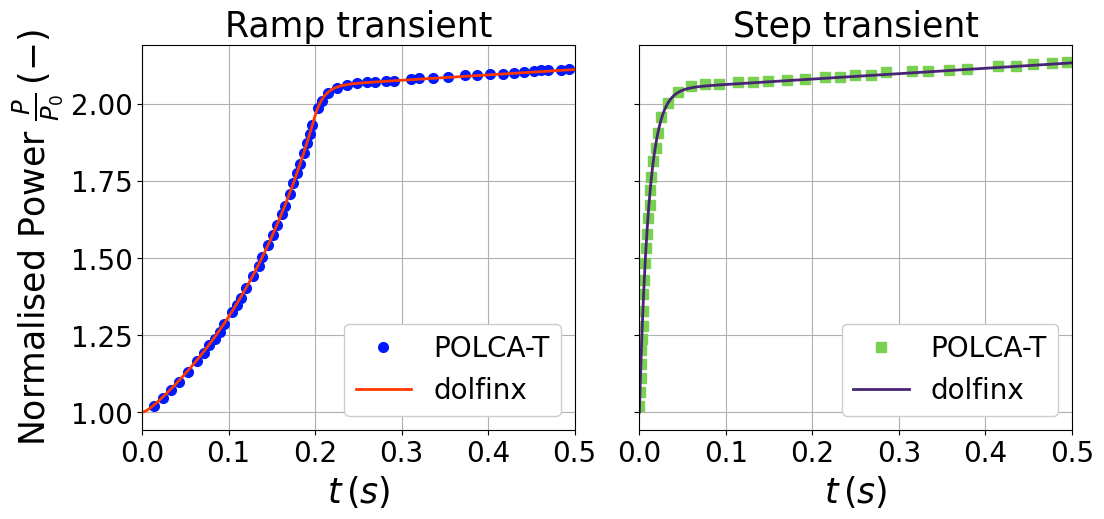

Step Transient: 100%|██████████| 500/500 [01:01<00:00, 11.66it/s]

In [11]:
# Load RAMP benchmark data
df = pd.read_csv(benchmark_path+'neutronics/TWIGL2D/POLCAramp_Power_time.csv')

bench_data = dict()
bench_data['Ramp'] = dict()
bench_data['Ramp']['t'] = df.to_numpy()[:, 0]
bench_data['Ramp']['Power'] = df.to_numpy()[:, 1]

# Load STEP benchmark data
df = pd.read_csv(benchmark_path+'neutronics/TWIGL2D/POLCAstep_Power_time.csv')

bench_data['Step'] = dict()
bench_data['Step']['t'] = df.to_numpy()[:, 0]
bench_data['Step']['Power'] = df.to_numpy()[:, 1]

mark_size = 7
ls = 2
labelsize = 25
tickssize = 20
legend_size = 20


fig = plt.figure(figsize=(12,5))
gs = fig.add_gridspec(1, 2, hspace=0.0, wspace=0.15)
axs = gs.subplots(sharex=True, sharey=True)

axs[0].plot(bench_data['Ramp']['t']-1, bench_data['Ramp']['Power'], 'o', color=cm.jet(0.15), markersize=mark_size, label=r'POLCA-T')
axs[0].plot(power_over_time['Ramp'][:, 0], power_over_time['Ramp'][:, 1] / reactor_power, '-', color=cm.jet(0.85), linewidth=ls, label = r'dolfinx')
axs[0].set_xlabel(r"$t\,(s)$",fontsize=labelsize)
axs[0].set_ylabel(r"Normalised Power $\frac{P}{P_0}\,(-)$",fontsize=labelsize)
axs[0].set_xlim(0,T)
axs[0].set_xticks(np.arange(0.0, .55, 0.1))
axs[0].tick_params(axis='x', labelsize=tickssize)
axs[0].tick_params(axis='y', labelsize=tickssize)
axs[0].grid(which='major',linestyle='-')
axs[0].grid(which='minor',linestyle='--')
axs[0].legend(fontsize=legend_size, framealpha=1)
axs[0].set_title('Ramp transient', fontsize=labelsize)

axs[1].plot(bench_data['Step']['t']-1, bench_data['Step']['Power'], 's', color=cm.viridis(0.8), markersize=mark_size,  label=r'POLCA-T')
axs[1].plot(power_over_time['Step'][:, 0], power_over_time['Step'][:, 1] / reactor_power, '-', color=cm.viridis(0.1), linewidth=ls, label = r'dolfinx')
axs[1].set_xlabel(r"$t\,(s)$",fontsize=labelsize)
axs[1].set_xlim(0,T)
axs[1].set_xticks(np.arange(0., .55, 0.1))
axs[1].tick_params(axis='x', labelsize=tickssize)
axs[1].grid(which='major',linestyle='-')
axs[1].grid(which='minor',linestyle='--')
axs[1].legend(fontsize=legend_size, framealpha=1, loc='lower right')
axs[1].set_title('Step transient', fontsize=labelsize)